In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image
%matplotlib inline

In [ ]:
import kagglehub

path = kagglehub.dataset_download("deeppythonist/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

100%|██████████| 151M/151M [00:00<00:00, 161MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/deeppythonist/brain-tumor-mri-dataset/versions/1


In [ ]:
train_path = os.path.join(path, "train")
test_path = os.path.join(path, "test")
train_path,test_path

('/root/.cache/kagglehub/datasets/deeppythonist/brain-tumor-mri-dataset/versions/1/train',
 '/root/.cache/kagglehub/datasets/deeppythonist/brain-tumor-mri-dataset/versions/1/test')

In [ ]:
dataset = keras.preprocessing.image_dataset_from_directory(train_path,shuffle=True,image_size=(256,256),batch_size=32)

Found 5723 files belonging to 4 classes.


In [ ]:

for root, dirs, files in os.walk(path):
    print("Directory:", root)
    if len(files) > 0:
        print("Files:", files)
        img = Image.open(os.path.join(root, files[0]))
        width, height = img.size
        print(f"Width: {width}, Height: {height}")


Directory: /root/.cache/kagglehub/datasets/deeppythonist/brain-tumor-mri-dataset/versions/1
Directory: /root/.cache/kagglehub/datasets/deeppythonist/brain-tumor-mri-dataset/versions/1/test
Directory: /root/.cache/kagglehub/datasets/deeppythonist/brain-tumor-mri-dataset/versions/1/test/meningioma
Files: ['me-0408.jpg', 'me-1450.jpg', 'me-1599.jpg', 'me-0100.jpg', 'me-0367.jpg', 'me-1656.jpg', 'me-1169.jpg', 'me-1517.jpg', 'me-0189.jpg', 'me-1558.jpg', 'me-1769.jpg', 'me-0621.jpg', 'me-1669.jpg', 'me-1495.jpg', 'me-0700.jpg', 'me-1646.jpg', 'me-0501.jpg', 'me-0613.jpg', 'me-0445.jpg', 'me-1075.jpg', 'me-0304.jpg', 'me-0525.jpg', 'me-1372.jpg', 'me-0659.jpg', 'me-1370.jpg', 'me-1243.jpg', 'me-1620.jpg', 'me-0910.jpg', 'me-0245.jpg', 'me-1671.jpg', 'me-0698.jpg', 'me-0055.jpg', 'me-0081.jpg', 'me-1064.jpg', 'me-0061.jpg', 'me-1303.jpg', 'me-0571.jpg', 'me-0224.jpg', 'me-1658.jpg', 'me-0629.jpg', 'me-0168.jpg', 'me-0360.jpg', 'me-1110.jpg', 'me-0388.jpg', 'me-0980.jpg', 'me-0316.jpg', 'me-0

In [ ]:
class_names = dataset.class_names
class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

In [ ]:
len(dataset)

179

(256, 256, 3)


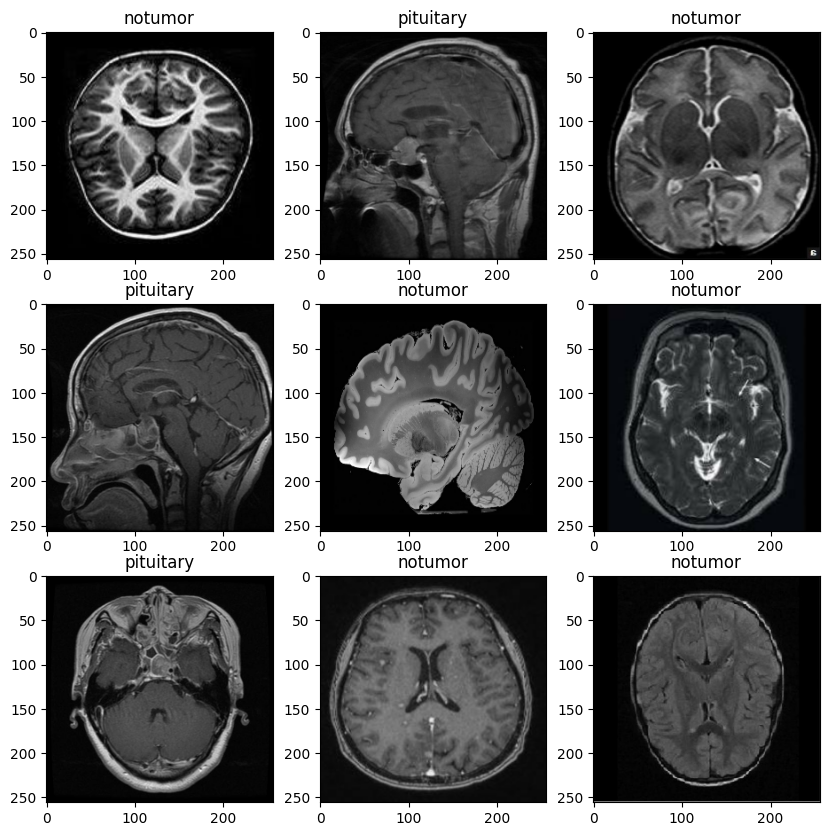

In [ ]:
plt.figure(figsize=(10,10))
for img,label in dataset.take(1):
  print(img[0].shape)
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(img[i].numpy().astype("uint8"))
    plt.title(class_names[label[i]])

In [ ]:
train_size = 0.8
len(dataset)*train_size

143.20000000000002

In [ ]:
train_data = dataset.take(143)
test_data = dataset.skip(143)
len(train_data),len(test_data)

(143, 36)

In [ ]:
validation_size = 0.1
len(dataset)*validation_size

17.900000000000002

In [ ]:
val_data = test_data.take(17)
test_data = test_data.skip(17)
len(val_data),len(test_data)

(17, 19)

In [ ]:
def data_splits(ds,train_split=0.8,test_split=0.1,val_split=0.1,shuffle=True,shuffle_size=10000):
  if shuffle:
    ds = ds.shuffle(shuffle_size,seed=12)

  train_size = int(len(ds)*train_split)
  val_size = int(len(ds)*val_split)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds,val_ds,test_ds


In [ ]:
train_ds,val_ds,test_ds = data_splits(dataset)
len(train_ds),len(val_ds),len(test_ds)

(143, 17, 19)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_rescale = keras.Sequential([
    keras.layers.Resizing(256,256),
    keras.layers.Rescaling(1./255,input_shape=(256,256,3))

])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(0.2)

])

In [ ]:
input_shape = (32,256,256,3)
n_classes = 4
model = keras.Sequential([
    resize_rescale,
    augmentation,
    keras.layers.Conv2D(32,kernel_size=(3,3),activation="relu",input_shape=input_shape),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64,kernel_size=(3,3),activation="relu",input_shape=input_shape),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64,kernel_size=(3,3),activation="relu",input_shape=input_shape),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64,kernel_size=(3,3),activation="relu",input_shape=input_shape),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64,activation="relu"),
    keras.layers.Dense(n_classes,activation="softmax"),

])
model.build(input_shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 12544)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 4)                │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,388 (3.42 MB)

 Trainable params: 896,388 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer="adam",loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=["accuracy"])
history = model.fit(train_ds,epochs=3,validation_data=val_ds,batch_size=32,verbose=1)

Epoch 1/3
143/143 ━━━━━━━━━━━━━━━━━━━━ 616s 4s/step - accuracy: 0.4998 - loss: 1.0935 - val_accuracy: 0.6728 - val_loss: 0.7591
Epoch 2/3
143/143 ━━━━━━━━━━━━━━━━━━━━ 577s 4s/step - accuracy: 0.7239 - loss: 0.6871 - val_accuracy: 0.6949 - val_loss: 0.7717
Epoch 3/3
143/143 ━━━━━━━━━━━━━━━━━━━━ 615s 4s/step - accuracy: 0.7638 - loss: 0.5820 - val_accuracy: 0.7757 - val_loss: 0.5025


In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
history.history["accuracy"]

[0.6029314994812012, 0.7271931767463684, 0.7691971063613892]

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

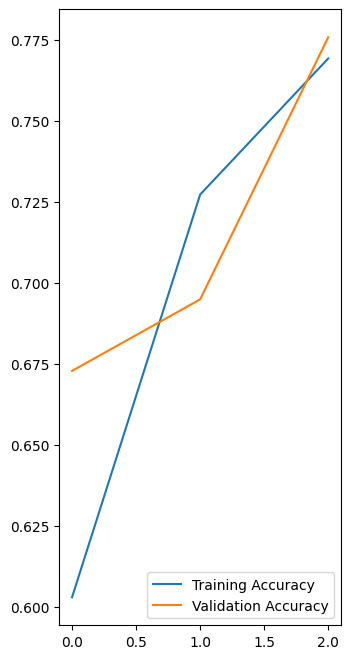

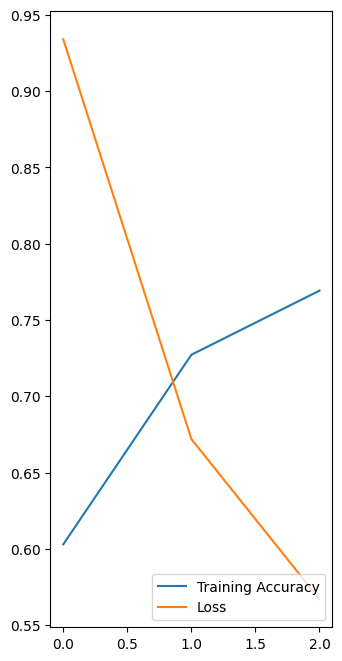

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(3),accuracy,label="Training Accuracy")
plt.plot(range(3),val_accuracy,label="Validation Accuracy")
plt.legend(loc="lower right")

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(3),accuracy,label="Training Accuracy")
plt.plot(range(3),loss,label="Loss")
plt.legend(loc="lower right")


In [ ]:
scores = model.evaluate(test_ds)
scores

19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.7576 - loss: 0.4856


[0.5255506634712219, 0.7532894611358643]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Original Label: meningioma
Predicted Label: glioma
Confidence: 0.44997668

Original Label: meningioma
Predicted Label: glioma
Confidence: 0.6444057

Original Label: glioma
Predicted Label: glioma
Confidence: 0.9306477

Original Label: notumor
Predicted Label: notumor
Confidence: 0.9826374

Original Label: glioma
Predicted Label: pituitary
Confidence: 0.39530793



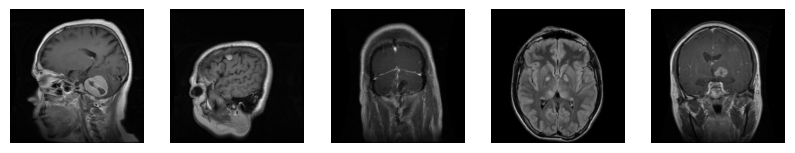

In [ ]:
import numpy as np
plt.figure(figsize=(10,10))
for imgs,label in test_ds.take(1):
  predictions = model.predict(imgs)
  for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(imgs[i].numpy().astype("uint8"))
    plt.axis("off")
    print("Original Label:",class_names[label[i]])
    print("Predicted Label:",class_names[np.argmax(predictions[i])])
    print("Confidence:",np.max(predictions[i]))
    print()

In [ ]:
model.save("brain_tumor_model.keras")